<a href="https://colab.research.google.com/github/alefram/Learning-AI/blob/master/convNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Convolutional NN

the most important is :
* Compositionality : many layers
* Convolutions: locality + stationarity of images
* Pooling: invariance of object class to translations and reduce data

In [2]:
# imports

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy
from torchvision import datasets, transforms

def get_n_params(model):
    np = 0
    for p in list(model.parameters()):
        np  += p.nelement()
    return np



In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# LOAD DATASET MNIST
input_size = 28*28 # images are 28x28 pixels
output_size = 10 # 10 clases


train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081, ))
    ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=1000, shuffle=True)


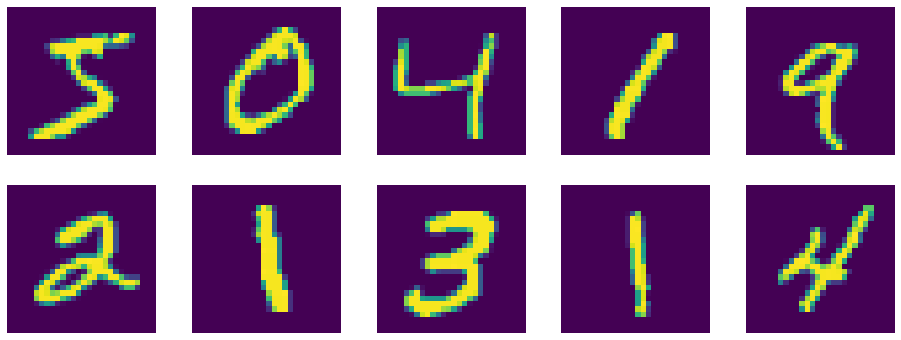

In [6]:
# SHOW IMAGES

plt.figure(figsize=(16, 6))

for i in range(10):
  plt.subplot(2, 5, i + 1)
  image, _ = train_loader.dataset.__getitem__(i)
  plt.imshow(image.squeeze().numpy())
  plt.axis('off')

 ## Create the model classes

In [22]:
class FC2Layer(nn.Module):
  def __init__(self, input_size, n_hidden, output_size):
    super(FC2Layer, self).__init__()
    self.input_size = input_size
    self.network = nn.Sequential(
        nn.Linear(input_size, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden, output_size),
        nn.LogSoftmax(dim=1)
    )

  def forward(self, x):
    x = x.view(-1, self.input_size)
    return self.network(x)

class CNN(nn.Module):
  def __init__(self, input_size, n_feature, output_size, kernel_size=5):
    super(CNN, self).__init__()
    self.n_feature = n_feature
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=kernel_size)
    self.conv2 = nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=kernel_size)
    self.fc1 = nn.Linear(n_feature * 4 * 4, 50)
    self.fc2 = nn.Linear(50, 10)

  def forward(self, x, verbose=False):
    c1 = self.conv1(x)
    s1 = F.relu(c1)
    p1 = F.max_pool2d(s1, kernel_size=2)
    c2 = self.conv2(p1)
    s2 = F.relu(c2)
    p2 = F.max_pool2d(s2, kernel_size=2)
    z1 = p2.view(-1, self.n_feature*4*4)
    z2 = self.fc1(z1)
    s3 = F.relu(z2)
    z3 = self.fc2(s3)
    loss = F.log_softmax(z3,  dim=1)

    return loss



## training

In [17]:
accuracy_list = []

def train(epoch, model, perm=torch.arange(0, 784).long()):
  model.train()

  for batch_idx, (data, target) in enumerate(train_loader):

    #send to gpu
    data, target = data.to(device),  target.to(device)

    #permute pixels
    data = data.view(-1, 28*28)
    data = data[:, perm]
    data = data.view(-1, 1, 28, 28)

    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()

    if batch_idx % 100 == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%]\tLoss: {:.6f}'.format(
          epoch, batch_idx * len(data), len(train_loader.dataset),
          100 * batch_idx / len(train_loader), loss.item()
      ))
    
def test(model, perm=torch.arange(0, 784).long()):
  model.eval()
  test_loss = 0
  correct = 0

  for data, target in test_loader:
    #send to devide
    data, target = data.to(device), target.to(device)

    #permute pixels
    data = data.view(-1, 28*28)
    data = data[:, perm]
    data = data.view(-1, 1, 28, 28)
    output = model(data)
    test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
    pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-prob
    correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()
  
  test_loss /= len(test_loader.dataset)
  accuracy = 100 * correct / len(test_loader.dataset)
  accuracy_list.append(accuracy)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      accuracy))



In [18]:
 # TRAINING FULL-CONNECTED NETWORK

 n_hidden = 8 

 model_fnn = FC2Layer(input_size, n_hidden, output_size)
 model_fnn.to(device)
 optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
 print('Number of parameters: {}'.format(get_n_params(model_fnn)))

 for epoch in range(0,1):
   train(epoch, model_fnn)
   test(model_fnn)


Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%]	Loss: 2.341375
Train Epoch: 0 [6400/60000 (11%]	Loss: 2.018996
Train Epoch: 0 [12800/60000 (21%]	Loss: 1.712312
Train Epoch: 0 [19200/60000 (32%]	Loss: 1.258846
Train Epoch: 0 [25600/60000 (43%]	Loss: 0.921238
Train Epoch: 0 [32000/60000 (53%]	Loss: 0.696469
Train Epoch: 0 [38400/60000 (64%]	Loss: 0.963029
Train Epoch: 0 [44800/60000 (75%]	Loss: 0.783512
Train Epoch: 0 [51200/60000 (85%]	Loss: 0.828146
Train Epoch: 0 [57600/60000 (96%]	Loss: 0.443338

Test set: Average loss: 0.5458, Accuracy: 8420/10000 (84%)



In [23]:
# TRAIN A CONVNET WITH THE SAME PARAMETERS

n_feature = 6 # number of feature maps

model_cnn = CNN(input_size, n_feature, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn)
    test(model_cnn)


Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%]	Loss: 2.311235
Train Epoch: 0 [6400/60000 (11%]	Loss: 1.762610
Train Epoch: 0 [12800/60000 (21%]	Loss: 0.810118
Train Epoch: 0 [19200/60000 (32%]	Loss: 0.509690
Train Epoch: 0 [25600/60000 (43%]	Loss: 0.242118
Train Epoch: 0 [32000/60000 (53%]	Loss: 0.207235
Train Epoch: 0 [38400/60000 (64%]	Loss: 0.216071
Train Epoch: 0 [44800/60000 (75%]	Loss: 0.178942
Train Epoch: 0 [51200/60000 (85%]	Loss: 0.246635
Train Epoch: 0 [57600/60000 (96%]	Loss: 0.145236

Test set: Average loss: 0.1893, Accuracy: 9413/10000 (94%)



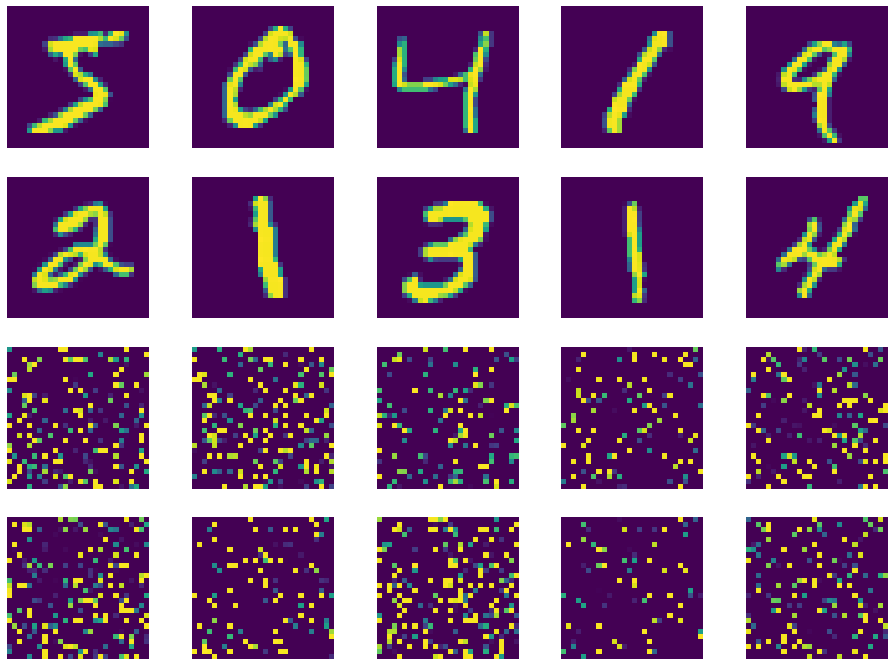

In [24]:
 # What happens if the assumptions are no longer true?
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_perm.squeeze().numpy())
    plt.axis('off')

In [25]:
# CONVNET WITH PERMUTED PIXELS 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%]	Loss: 2.305732
Train Epoch: 0 [6400/60000 (11%]	Loss: 2.282792
Train Epoch: 0 [12800/60000 (21%]	Loss: 2.184458
Train Epoch: 0 [19200/60000 (32%]	Loss: 1.908564
Train Epoch: 0 [25600/60000 (43%]	Loss: 1.171230
Train Epoch: 0 [32000/60000 (53%]	Loss: 0.932901
Train Epoch: 0 [38400/60000 (64%]	Loss: 0.717290
Train Epoch: 0 [44800/60000 (75%]	Loss: 0.650081
Train Epoch: 0 [51200/60000 (85%]	Loss: 0.426493
Train Epoch: 0 [57600/60000 (96%]	Loss: 0.650017

Test set: Average loss: 0.5291, Accuracy: 8323/10000 (83%)



In [26]:
# FULL-CONNECTED WITH PERMUTED PIXELS
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%]	Loss: 2.332795
Train Epoch: 0 [6400/60000 (11%]	Loss: 1.937962
Train Epoch: 0 [12800/60000 (21%]	Loss: 1.873135
Train Epoch: 0 [19200/60000 (32%]	Loss: 1.532827
Train Epoch: 0 [25600/60000 (43%]	Loss: 1.402746
Train Epoch: 0 [32000/60000 (53%]	Loss: 1.323815
Train Epoch: 0 [38400/60000 (64%]	Loss: 1.146790
Train Epoch: 0 [44800/60000 (75%]	Loss: 1.021183
Train Epoch: 0 [51200/60000 (85%]	Loss: 0.860318
Train Epoch: 0 [57600/60000 (96%]	Loss: 0.719421

Test set: Average loss: 0.6613, Accuracy: 8056/10000 (81%)



* ConvNet makes the assumption that pixels lie on a grid and are stationary/local
* It loses performance when this assumption is wrong
* The fully-connected network does not make this assumption
* It does less well when it is true, since it doesn't take advantage of this prior knowledge
* But it doesn't suffer when the assumption is wrong

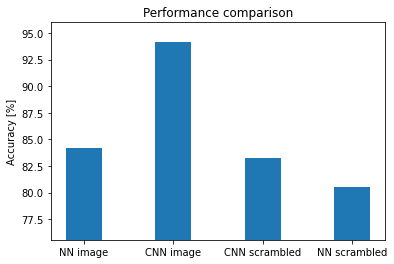

In [31]:
#ANALYSIS
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4)
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(10)
plt.title('Performance comparison');

In [35]:
# check model parameters

print("full connected")
print(dir(model_cnn))

print("-----------------------------------------------------")

print("convolutional")
print(dir(model_fnn))

full connected
['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_buffers', '_call_impl', '_forward_hooks', '_forward_pre_hooks', '_get_backward_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hook', '_register_state_dict_hook', '_replicate_for_data_parallel', '_save_to_state_dict', '_slow_forward', '_state_dict_hooks', '_version', 'add_module', 'apply', 'bfloat16